## Simple Recommender system

In [0]:
import pandas as pd 
import numpy as np


In [48]:
# Load Movies credit
df1 = pd.read_csv('/content/drive/My Drive/138_4508_bundle_archive/tmdb_5000_credits.csv')

# Print the first three rows
df1.head()

,movie_id,title,cast,crew
0,19995,Avatar,"[{""cast_id"": 242, ""character"": ""Jake Sully"", ""...","[{""credit_id"": ""52fe48009251416c750aca23"", ""de..."
1,285,Pirates of the Caribbean: At World's End,"[{""cast_id"": 4, ""character"": ""Captain Jack Spa...","[{""credit_id"": ""52fe4232c3a36847f800b579"", ""de..."
2,206647,Spectre,"[{""cast_id"": 1, ""character"": ""James Bond"", ""cr...","[{""credit_id"": ""54805967c3a36829b5002c41"", ""de..."
3,49026,The Dark Knight Rises,"[{""cast_id"": 2, ""character"": ""Bruce Wayne / Ba...","[{""credit_id"": ""52fe4781c3a36847f81398c3"", ""de..."
4,49529,John Carter,"[{""cast_id"": 5, ""character"": ""John Carter"", ""c...","[{""credit_id"": ""52fe479ac3a36847f813eaa3"", ""de..."


In [0]:
# Load Movies 
df2 = pd.read_csv('/content/drive/My Drive/138_4508_bundle_archive/tmdb_5000_movies.csv')

# Print the first three rows
df2.head()

In [50]:
# merge two tables on movie_id
df1.columns = ['id','movie_title','cast','crew']
df2 = df2.merge(df1, on='id')
df2.head()
# dataset.drop('title_y', axis=1).head()

,budget,genres,homepage,id,keywords,original_language,original_title,overview,popularity,production_companies,production_countries,release_date,revenue,runtime,spoken_languages,status,tagline,title,vote_average,vote_count,movie_title,cast,crew
0,237000000,"[{""id"": 28, ""name"": ""Action""}, {""id"": 12, ""nam...",http://www.avatarmovie.com/,19995,"[{""id"": 1463, ""name"": ""culture clash""}, {""id"":...",en,Avatar,"In the 22nd century, a paraplegic Marine is di...",150.437577,"[{""name"": ""Ingenious Film Partners"", ""id"": 289...","[{""iso_3166_1"": ""US"", ""name"": ""United States o...",2009-12-10,2787965087,162.0,"[{""iso_639_1"": ""en"", ""name"": ""English""}, {""iso...",Released,Enter the World of Pandora.,Avatar,7.2,11800,Avatar,"[{""cast_id"": 242, ""character"": ""Jake Sully"", ""...","[{""credit_id"": ""52fe48009251416c750aca23"", ""de..."
1,300000000,"[{""id"": 12, ""name"": ""Adventure""}, {""id"": 14, ""...",http://disney.go.com/disneypictures/pirates/,285,"[{""id"": 270, ""name"": ""ocean""}, {""id"": 726, ""na...",en,Pirates of the Caribbean: At World's End,"Captain Barbossa, long believed to be dead, ha...",139.082615,"[{""name"": ""Walt Disney Pictures"", ""id"": 2}, {""...","[{""iso_3166_1"": ""US"", ""name"": ""United States o...",2007-05-19,961000000,169.0,"[{""iso_639_1"": ""en"", ""name"": ""English""}]",Released,"At the end of the world, the adventure begins.",Pirates of the Caribbean: At World's End,6.9,4500,Pirates of the Caribbean: At World's End,"[{""cast_id"": 4, ""character"": ""Captain Jack Spa...","[{""credit_id"": ""52fe4232c3a36847f800b579"", ""de..."
2,245000000,"[{""id"": 28, ""name"": ""Action""}, {""id"": 12, ""nam...",http://www.sonypictures.com/movies/spectre/,206647,"[{""id"": 470, ""name"": ""spy""}, {""id"": 818, ""name...",en,Spectre,A cryptic message from Bond’s past sends him o...,107.376788,"[{""name"": ""Columbia Pictures"", ""id"": 5}, {""nam...","[{""iso_3166_1"": ""GB"", ""name"": ""United Kingdom""...",2015-10-26,880674609,148.0,"[{""iso_639_1"": ""fr"", ""name"": ""Fran\u00e7ais""},...",Released,A Plan No One Escapes,Spectre,6.3,4466,Spectre,"[{""cast_id"": 1, ""character"": ""James Bond"", ""cr...","[{""credit_id"": ""54805967c3a36829b5002c41"", ""de..."
3,250000000,"[{""id"": 28, ""name"": ""Action""}, {""id"": 80, ""nam...",http://www.thedarkknightrises.com/,49026,"[{""id"": 849, ""name"": ""dc comics""}, {""id"": 853,...",en,The Dark Knight Rises,Following the death of District Attorney Harve...,112.312950,"[{""name"": ""Legendary Pictures"", ""id"": 923}, {""...","[{""iso_3166_1"": ""US"", ""name"": ""United States o...",2012-07-16,1084939099,165.0,"[{""iso_639_1"": ""en"", ""name"": ""English""}]",Released,The Legend Ends,The Dark Knight Rises,7.6,9106,The Dark Knight Rises,"[{""cast_id"": 2, ""character"": ""Bruce Wayne / Ba...","[{""credit_id"": ""52fe4781c3a36847f81398c3"", ""de..."
4,260000000,"[{""id"": 28, ""name"": ""Action""}, {""id"": 12, ""nam...",http://movies.disney.com/john-carter,49529,"[{""id"": 818, ""name"": ""based on novel""}, {""id"":...",en,John Carter,"John Carter is a war-weary, former military ca...",43.926995,"[{""name"": ""Walt Disney Pictures"", ""id"": 2}]","[{""iso_3166_1"": ""US"", ""name"": ""United States o...",2012-03-07,284139100,132.0,"[{""iso_639_1"": ""en"", ""name"": ""English""}]",Released,"Lost in our world, found in another.",John Carter,6.1,2124,John Carter,"[{""cast_id"": 5, ""character"": ""John Carter"", ""c...","[{""credit_id"": ""52fe479ac3a36847f813eaa3"", ""de..."


# Demographic Filtering


I would use a weighted rating that takes into account the average rating and the number of votes it has accumulated. Such a system will make sure that a movie with a 9 rating from 100,000 voters gets a (far) higher score than a movie with the same rating but a mere few hundred voters.

WeightedRating(WR)= ((v/v+m)⋅R)+((m/v+m)⋅C)

* v is the number of votes for the movie;

* m is the minimum votes required to be listed in the chart;

* R is the average rating of the movie;

* C is the mean vote across the whole report.

I already have the values to v ```(vote_count)``` and R```(vote_average)``` for each movie in the dataset. It is also possible to directly calculate C from this data.

In [51]:
# Calculate mean of vote average column
C = df2['vote_average'].mean()
print(C)

6.092171559442011


In [53]:
# Calculate the minimum number of votes required to be in the chart, m , coverage parameter
m = df2['vote_count'].quantile(0.90)
print(m)

1838.4000000000015


In [54]:
# Filter out all qualified movies into a new DataFrame
q_movies = df2.copy().loc[df2['vote_count'] >= m]
q_movies.shape

(481, 23)

In [55]:
q_movies.describe()

,budget,id,popularity,revenue,runtime,vote_average,vote_count
count,4.810000e+02,481.000000,481.000000,4.810000e+02,481.000000,481.000000,481.000000
mean,8.990394e+07,62551.962578,78.995904,3.942767e+08,121.347193,6.962994,3684.035343
std,6.856570e+07,86305.467810,68.505897,3.200686e+08,22.070107,0.750335,1913.572690
min,0.000000e+00,11.000000,1.859364,1.000000e+06,77.000000,4.400000,1840.000000
25%,3.000000e+07,694.000000,49.549984,1.601127e+08,106.000000,6.400000,2311.000000
50%,7.500000e+07,18360.000000,65.677399,3.201700e+08,119.000000,7.000000,3041.000000
75%,1.400000e+08,82702.000000,89.186492,5.442724e+08,133.000000,7.600000,4442.000000
max,3.800000e+08,333371.000000,875.581305,2.787965e+09,201.000000,8.500000,13752.000000


In [0]:
# Function that computes the weighted rating of each movie
def weighted_rating(x, m=m, C=C):
    v = x['vote_count']
    R = x['vote_average']
    # Calculation based on the IMDB formula
    return (v/(v+m) * R) + (m/(m+v) * C)

In [0]:
# Define a new feature 'score' and calculate its value with `weighted_rating()`
q_movies['score'] = q_movies.apply(weighted_rating, axis=1)

In [57]:
#Sort movies based on score calculated above
q_movies = q_movies.sort_values('score', ascending=False)

#Print the top 15 movies
q_movies[['title', 'vote_count', 'vote_average', 'score']].head()

,title,vote_count,vote_average,score
1881,The Shawshank Redemption,8205,8.5,8.444879
3337,The Godfather,5893,8.4,8.326468
662,Fight Club,9413,8.3,8.255177
3232,Pulp Fiction,8428,8.3,8.250036
1818,Schindler's List,4329,8.3,8.204414


Text(0.5, 1.0, 'Top 10 Popular Movies')

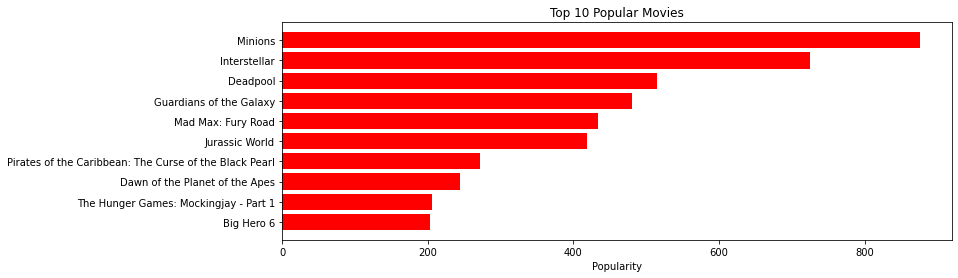

In [66]:
import matplotlib.pyplot as plt

pop= df2.sort_values('popularity', ascending=False)
plt.figure(figsize=(12,4))

plt.barh(pop['title'].head(10),pop['popularity'].head(10), align='center',
        color='red')
plt.gca().invert_yaxis()
plt.xlabel("Popularity")
plt.title("Top 10 Popular Movies")

In [10]:
#Print overviews of the first 5 movies.
metadata['overview'].head()

0    Led by Woody, Andy's toys live happily in his ...
1    When siblings Judy and Peter discover an encha...
2    A family wedding reignites the ancient feud be...
3    Cheated on, mistreated and stepped on, the wom...
4    Just when George Banks has recovered from his ...
Name: overview, dtype: object

In [11]:
#Import TfIdfVectorizer from scikit-learn
from sklearn.feature_extraction.text import TfidfVectorizer

#Define a TF-IDF Vectorizer Object. Remove all english stop words such as 'the', 'a'
tfidf = TfidfVectorizer(stop_words='english')

#Replace NaN with an empty string
metadata['overview'] = metadata['overview'].fillna('')

#Construct the required TF-IDF matrix by fitting and transforming the data
tfidf_matrix = tfidf.fit_transform(metadata['overview'])

#Output the shape of tfidf_matrix
tfidf_matrix.shape

(45466, 75827)

In [12]:
#Array mapping from feature integer indices to feature name.
tfidf.get_feature_names()[5000:5010]

['avails',
 'avaks',
 'avalanche',
 'avalanches',
 'avallone',
 'avalon',
 'avant',
 'avanthika',
 'avanti',
 'avaracious']

In [15]:
# Import linear_kernel
from sklearn.metrics.pairwise import linear_kernel

# Compute the cosine similarity matrix
cosine_sim = linear_kernel(tfidf_matrix, tfidf_matrix)

KeyboardInterrupt: ignored

In [14]:
cosine_sim

array([[1.        , 0.01504121, 0.        , ..., 0.        , 0.00595453,
        0.        ],
       [0.01504121, 1.        , 0.04681953, ..., 0.        , 0.02198641,
        0.00929411],
       [0.        , 0.04681953, 1.        , ..., 0.        , 0.01402548,
        0.        ],
       ...,
       [0.        , 0.        , 0.00640162, ..., 0.        , 0.005271  ,
        0.        ],
       [0.        , 0.1025322 , 0.        , ..., 0.03826847, 0.        ,
        0.        ],
       [0.        , 0.        , 0.        , ..., 0.        , 0.        ,
        0.        ]])